<a href="https://colab.research.google.com/github/creadal/informacionnij_poisk/blob/main/informacionnij_poisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/creadal/informacionnij_poisk.git

Cloning into 'informacionnij_poisk'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [3]:
from informacionnij_poisk import reader

In [5]:
filename = '/content/drive/MyDrive/habr.json'
test_reader = reader.read(filename, n_articles=1)

In [6]:
for article in test_reader:
  main_body = article['main_body']
  print(reader.clean(main_body[:500]), '...')

Смотри ты устроился работать в большую компанию где много команд каждая разрабатывает свой продукт часть из них создаёт микросервисы вокруг ядра часть создаёт свои отдельные полноценные продукты И допустим вся разработка до сих пор не использует централизованное хранение кода работает без CI CD и без наработок DevOps Твоей первой задачей поставили организовать подход к хранению исходного кода в рамках всей компании По секрету скажу большие компании любят когда используется единый по ...


Проанализируем разные элементы статей:

Начнем с заголовков. Построим словарь для заголовков и расчитаем частоты употребления слов.

Для анализа текста нам понадобится обработка слов. Напишем функцию для простого стемминга, которая будет удалять окончания слов из списка окончаний.

In [7]:
def stem(word):
  endings = ['ами', 'ями', 'ого', 'его', 'ому', 'ему', 'ими', 'ыми', 'ов', 'ей',
             'ам', 'ям', 'ой', 'ей', 'ом', 'ем', 'ах', 'ях', 'ой', 'ий', 'ый', 'ая',
              'яя', 'ое', 'ее', 'ие', 'ые', 'ой', 'ей', 'их', 'ых', 'им', 'ым', 'а',
              'я', 'и', 'ы', 'о', 'е', 'и', 'ы', 'а', 'я', 'у', 'ю']
  for ending in endings:
    if word[-len(ending):] == ending:
      return word[:-len(ending)]
  
  return word

Так как работа с файлов ведется посредством вызова генератора, каждый раз при обращении к базе, генератор придется обновлять.

In [8]:
all_reader = reader.read(filename)

Сформируем словарь:

In [9]:
from tqdm.notebook import tqdm

In [10]:
title_dict = {}

for article in tqdm(all_reader):
  for word in reader.clean(article['title']).split():
    stemmed = stem(stem(word))
    if stemmed not in title_dict.keys():
      title_dict[stemmed] = 1
    else:
      title_dict[stemmed] += 1

0it [00:00, ?it/s]

Отсортируем и посмотрим что получилось

In [11]:
title_dict = dict(sorted(title_dict.items(), key=lambda item: item[1], reverse=True))
title_dict

{'в': 24195,
 '': 23014,
 'н': 21697,
 'дл': 11793,
 'с': 11187,
 '—': 11157,
 'Google': 4636,
 'Как': 4631,
 'п': 4257,
 '2': 4000,
 'от': 3980,
 'ил': 3758,
 '1': 3507,
 'з': 3232,
 'из': 2967,
 'как': 2960,
 'Н': 2814,
 'к': 2540,
 'Windows': 2520,
 'приложен': 2417,
 '3': 2340,
 '0': 2287,
 'сайт': 2156,
 'В': 2155,
 'Часть': 2098,
 'пр': 1961,
 'св': 1943,
 'Android': 1882,
 '5': 1708,
 'Microsoft': 1644,
 'интернет': 1595,
 'работ': 1574,
 'год': 1562,
 'игр': 1552,
 '–': 1540,
 'проект': 1538,
 '4': 1525,
 'сист': 1521,
 'л': 1497,
 '10': 1425,
 'т': 1391,
 'данн': 1372,
 '7': 1349,
 'перв': 1329,
 'чт': 1328,
 'сервис': 1300,
 'помощь': 1238,
 'веб': 1238,
 'Росс': 1235,
 'м': 1220,
 'эт': 1213,
 'д': 1212,
 'Linux': 1205,
 'мобильн': 1184,
 'верс': 1183,
 'Чт': 1154,
 'разработчик': 1128,
 'ru': 1121,
 'Apple': 1119,
 'под': 1110,
 'вс': 1104,
 'Обзор': 1097,
 'Яндекс': 1091,
 'iPhone': 1084,
 'пользовател': 1084,
 '8': 1081,
 'сервер': 1062,
 'разработк': 1042,
 'вид': 1016,


Почистим данные от коротких слов, а также от стоп-слов из списка

In [13]:
stop_words = []
with open('stop-ru.txt') as file:
  stop_words.append(file.readline().strip())

for stop_word in stop_words:
  if stop_word in title_dict.keys():
    del title_dict[stop_word]
  if stem(stop_word) in title_dict.keys():
    del title_dict[stem(stop_word)] 

short = []
for key in title_dict.keys():
  if len(key) < 5:
    short.append(key)

for key in short:
  del title_dict[key]

len(title_dict), title_dict

(67635,
 {'Google': 4636,
  'Windows': 2520,
  'приложен': 2417,
  'Часть': 2098,
  'Android': 1882,
  'Microsoft': 1644,
  'интернет': 1595,
  'работ': 1574,
  'проект': 1538,
  'сервис': 1300,
  'помощь': 1238,
  'Linux': 1205,
  'мобильн': 1184,
  'разработчик': 1128,
  'Apple': 1119,
  'Обзор': 1097,
  'Яндекс': 1091,
  'iPhone': 1084,
  'пользовател': 1084,
  'сервер': 1062,
  'разработк': 1042,
  'поиск': 1014,
  'часть': 978,
  'компан': 959,
  'использован': 950,
  'котор': 926,
  'стартап': 858,
  'через': 801,
  'больш': 761,
  'будет': 749,
  'Firefox': 729,
  'бесплатн': 716,
  'прост': 704,
  'Интернет': 701,
  'создан': 700,
  'телефон': 694,
  'программ': 671,
  'Opera': 670,
  'интерфейс': 668,
  'социальн': 667,
  'теперь': 664,
  'клиент': 662,
  'программирован': 651,
  'Ubuntu': 641,
  'технолог': 620,
  'пример': 608,
  'бизнес': 608,
  'браузер': 606,
  'способ': 598,
  'Samsung': 596,
  'конференц': 595,
  'управлен': 588,
  'смартфон': 587,
  'устройств': 587,
 

Получившийся словарь удобен для использования моделей, таких как например bag of words. 

Отсортируем "хабы" и тэги статей по популярности.

In [14]:
all_reader = reader.read(filename)

In [15]:
hubs = {}

for article in tqdm(all_reader):
  for hub in article['hubs']:
    hub = hub.lower()
    if hub not in hubs.keys():
      hubs[hub] = 1
    else:
      hubs[hub] += 1

hubs = dict(sorted(hubs.items(), key=lambda item: item[1], reverse=True))
hubs

0it [00:00, ?it/s]

{'чулан': 29343,
 'it-компании': 7010,
 'разработка веб-сайтов': 5459,
 'я пиарюсь': 4950,
 'информационная безопасность': 4100,
 'программирование': 2977,
 'компьютерное железо': 2292,
 'настройка linux': 2283,
 'гаджеты': 2269,
 'разработка под android': 1981,
 'javascript': 1928,
 'социальные сети и сообщества': 1782,
 'habr': 1636,
 '.net': 1611,
 'php': 1525,
 'разработка игр': 1477,
 'diy или сделай сам': 1360,
 'open source': 1333,
 'смартфоны': 1260,
 'научно-популярное': 1176,
 'java': 1154,
 'системное администрирование': 1152,
 'алгоритмы': 1147,
 'разработка мобильных приложений': 1137,
 'интерфейсы': 1133,
 'python': 1122,
 'управление проектами': 935,
 'разработка под ios': 919,
 'игры и игровые консоли': 862,
 'блог компании microsoft': 859,
 'софт': 852,
 'c++': 834,
 'дизайн': 828,
 'копирайт': 824,
 'gtd': 783,
 'законодательство в it': 762,
 'космонавтика': 740,
 'учебный процесс в it': 730,
 'финансы в it': 704,
 'робототехника': 699,
 'css': 664,
 'firefox': 614,
 

Мы можем видеть, что в конце списка находятся хабы с названием "Блог компании N". Подобные хабы являются лишь указанием авторства статьи и не представляют для нас никакой ценности. Так что можем просто от них избавиться.

In [16]:
blog = []

for key in hubs.keys():
  if key[:len('блог компании')] == 'блог компании':
    blog.append(key)

for b in blog:
  del hubs[b]

In [17]:
hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

In [18]:
len(hubs), hubs

(425,
 [('чулан', 29343),
  ('it-компании', 7010),
  ('разработка веб-сайтов', 5459),
  ('я пиарюсь', 4950),
  ('информационная безопасность', 4100),
  ('программирование', 2977),
  ('компьютерное железо', 2292),
  ('настройка linux', 2283),
  ('гаджеты', 2269),
  ('разработка под android', 1981),
  ('javascript', 1928),
  ('социальные сети и сообщества', 1782),
  ('habr', 1636),
  ('.net', 1611),
  ('php', 1525),
  ('разработка игр', 1477),
  ('diy или сделай сам', 1360),
  ('open source', 1333),
  ('смартфоны', 1260),
  ('научно-популярное', 1176),
  ('java', 1154),
  ('системное администрирование', 1152),
  ('алгоритмы', 1147),
  ('разработка мобильных приложений', 1137),
  ('интерфейсы', 1133),
  ('python', 1122),
  ('управление проектами', 935),
  ('разработка под ios', 919),
  ('игры и игровые консоли', 862),
  ('софт', 852),
  ('c++', 834),
  ('дизайн', 828),
  ('копирайт', 824),
  ('gtd', 783),
  ('законодательство в it', 762),
  ('космонавтика', 740),
  ('учебный процесс в it'

Теперь найдем самые популярные теги

In [19]:
all_reader = reader.read(filename)

In [20]:
tags = {}

for article in tqdm(all_reader):
  for tag in article['tags']:
    tag = tag.lower()
    if tag not in tags.keys():
      tags[tag] = 1
    else:
      tags[tag] += 1

tags = sorted(tags.items(), key=lambda item: item[1], reverse=True)
tags

0it [00:00, ?it/s]

[('google', 4772),
 ('android', 3226),
 ('microsoft', 3146),
 ('apple', 2987),
 ('linux', 2796),
 ('javascript', 2450),
 ('php', 2321),
 ('iphone', 1780),
 ('социальные сети', 1590),
 ('java', 1545),
 ('python', 1490),
 ('стартапы', 1476),
 ('программирование', 1428),
 ('стартап', 1369),
 ('яндекс', 1357),
 ('игры', 1350),
 ('хабрахабр', 1264),
 ('дизайн', 1197),
 ('windows', 1193),
 ('интернет', 1153),
 ('.net', 1095),
 ('firefox', 1092),
 ('юмор', 1069),
 ('видео', 1024),
 ('facebook', 1019),
 ('реклама', 1017),
 ('css', 1016),
 ('ios', 1014),
 ('opera', 1007),
 ('ubuntu', 978),
 ('open source', 966),
 ('разработка', 963),
 ('безопасность', 943),
 ('twitter', 876),
 ('работа', 849),
 ('nokia', 848),
 ('юзабилити', 826),
 ('обзор', 813),
 ('веб 2.0', 812),
 ('статистика', 773),
 ('samsung', 758),
 ('jquery', 743),
 ('html5', 737),
 ('intel', 718),
 ('конференция', 711),
 ('html', 710),
 ('youtube', 706),
 ('поиск', 705),
 ('бизнес', 696),
 ('c++', 696),
 ('конкурс', 695),
 ('ruby', 66

Теперь давайте посчитаем связь между разными признаками статей и целевым признаком - оценкой пользователей.

Начнем с подсчета зависимости от длины названия в словах и длины всего текста.

In [21]:
all_reader = reader.read(filename)

In [22]:
lengths = {}

for article in tqdm(all_reader):
  length = len(reader.clean(article['title']).split())
  rating = article['rating']
  if length not in lengths.keys():
    lengths[length] = [rating, 1]
  else:
    lengths[length][0] += rating
    lengths[length][1] += 1

for key, value in lengths.items():
  lengths[key].append(value[0] / value[1])

lengths = [(key, value[2], value[1]) for key, value in lengths.items()]

0it [00:00, ?it/s]

In [23]:
lengths = sorted(lengths)
lengths

[(0, 10.857142857142858, 7),
 (1, 18.800875273522976, 1371),
 (2, 26.128019749603244, 5671),
 (3, 27.710719257540603, 10775),
 (4, 27.540885805071007, 15421),
 (5, 26.251265324485434, 17782),
 (6, 26.48437139561707, 17340),
 (7, 26.067557874144114, 15335),
 (8, 25.122883123383666, 11987),
 (9, 25.56028210007836, 8933),
 (10, 25.66840277777778, 6336),
 (11, 23.99099301959018, 4441),
 (12, 24.807868852459016, 3050),
 (13, 23.940782698249226, 1942),
 (14, 22.98986975397974, 1382),
 (15, 22.453191489361704, 940),
 (16, 24.013698630136986, 657),
 (17, 22.36036036036036, 444),
 (18, 28.33061224489796, 245),
 (19, 24.099378881987576, 161),
 (20, 30.661016949152543, 118),
 (21, 22.857142857142858, 42),
 (22, 41.03703703703704, 27),
 (23, 16.45, 20),
 (24, 28.9, 10),
 (25, 8.4, 10),
 (26, 73.25, 4),
 (27, 4.0, 3),
 (28, 21.0, 6),
 (29, 224.0, 1),
 (30, 47.0, 1),
 (37, 57.0, 1)]

Для большей наглядности построим график

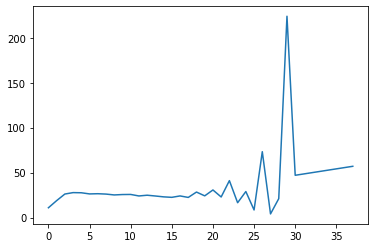

In [24]:
import matplotlib.pyplot as plt

plt.plot([e[0] for e in lengths], [e[1] for e in lengths])

Мы можем видеть, что график довольно ровный для "нормальных" длин заголовков, и очень сильно разнится для больших длин. Однако это легко объясняется тем, что статей с такими большими длинами заголовков слишком мало, чтобы считать выборку репрезентативной. 
Вывод: из графика вполне очевидно вытекает, что оценка поста не зависит от длины его заголовка.

Посчитаем то же самое для длины самого текста статьи. Для удобства мы будем рассматривать только промежутки в 300 слов.

In [25]:
all_reader = reader.read(filename)

In [26]:
lengths = {}

for article in tqdm(all_reader):
  length = len(reader.clean(article['main_body']).split()) // 300
  rating = article['rating']
  if length not in lengths.keys():
    lengths[length] = [rating, 1]
  else:
    lengths[length][0] += rating
    lengths[length][1] += 1

for key, value in lengths.items():
  lengths[key].append(value[0] / value[1])

lengths = [(key, value[2], value[1]) for key, value in lengths.items()]

0it [00:00, ?it/s]

In [27]:
lengths = sorted(lengths)
lengths

[(0, 14.719749423013518, 15165),
 (1, 17.629544921416844, 17052),
 (2, 21.461650896222785, 12999),
 (3, 22.51817186099771, 10043),
 (4, 23.90173410404624, 7958),
 (5, 25.20462270564242, 5884),
 (6, 26.037346129772587, 4793),
 (7, 26.492158327109784, 4017),
 (8, 27.038544474393532, 3710),
 (9, 29.37912578055308, 3363),
 (10, 30.011154855643046, 3048),
 (11, 30.382257482870536, 2773),
 (12, 30.900823206585653, 2551),
 (13, 32.769722814498934, 2345),
 (14, 33.14486192847442, 2209),
 (15, 33.179979777553086, 1978),
 (16, 32.98928188638799, 1866),
 (17, 32.92018779342723, 1704),
 (18, 34.88706500328299, 1523),
 (19, 34.819148936170215, 1410),
 (20, 36.53739398612182, 1297),
 (21, 41.38192182410423, 1228),
 (22, 38.43805309734513, 1130),
 (23, 35.74213197969543, 985),
 (24, 40.801832760595644, 873),
 (25, 37.53171856978086, 867),
 (26, 40.44102564102564, 780),
 (27, 39.41547277936963, 698),
 (28, 38.3819018404908, 652),
 (29, 37.73848684210526, 608),
 (30, 37.296596434359806, 617),
 (31, 37.

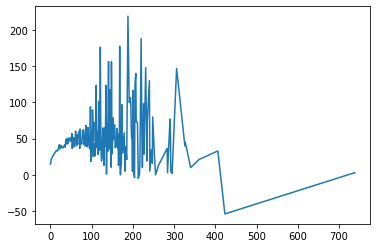

In [28]:
import matplotlib.pyplot as plt

plt.plot([e[0] for e in lengths], [e[1] for e in lengths])

График имеет очень хаотичную структуру, однако это также легко объясняется слишком маленькой выборкой статей большой длины. Давайте рассмотрим лишь часть графика, скажем, до 50 ( с учетом нашего деления на 300 это статьи длинной до 15000 слов).

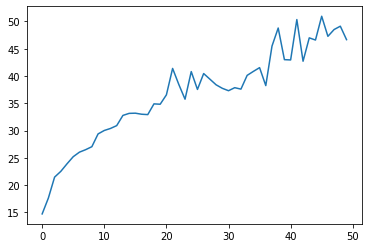

In [29]:
import matplotlib.pyplot as plt

plt.plot([e[0] for e in lengths[:50]], [e[1] for e in lengths[:50]])

Теперь все встало на свои места. Очевидна зависимость между длиной статьи и рейтингом. Это возможно объясняется тем, что хабр - ресурс для специалистов, которые предпочитают глубокий и долгий анализ темы вместо поверхностных и обзорных статей. 

Теперь проверим зависимость рейтинга от тегов и хабов

In [30]:
all_reader = reader.read(filename)

In [31]:
tags_names = [t[0] for t in tags]

In [32]:
tags_with_rating = {}

for article in tqdm(all_reader):
  for tag in article['tags']:
    tag = tag.lower()
    if tag in tags_names:
      if tag not in tags_with_rating.keys():
        tags_with_rating[tag] = [article['rating'], 1]
      else:
        tags_with_rating[tag][0] += article['rating']
        tags_with_rating[tag][1] += 1

tags_with_rating

0it [00:00, ?it/s]

{'git': [10203, 263],
 'git workflow': [605, 9],
 'scm': [622, 23],
 'devops': [1380, 123],
 'notops': [0, 1],
 'open-source': [1417, 60],
 'email': [3906, 141],
 'google translate': [1687, 66],
 'машинный перевод': [562, 20],
 'bleu': [0, 1],
 'nlp': [1705, 59],
 'nlp (natural language processing)': [54, 7],
 'taus': [0, 1],
 'перевод': [16903, 487],
 'переводчик': [1134, 40],
 'автоматический перевод': [51, 5],
 'машинное обучение': [3129, 149],
 'солнечная энергетика': [782, 19],
 'виэ': [6, 2],
 'энергия': [2056, 62],
 'солнце': [1325, 29],
 'батареи': [338, 17],
 'физика': [7945, 173],
 'коммерция': [574, 30],
 'двигатель': [188, 6],
 'ркк энергия': [36, 5],
 'роскосмос': [3731, 70],
 'луна': [3112, 82],
 'луна-25': [211, 6],
 'лунная программа': [25, 3],
 'экскаватор': [56, 2],
 'патент': [1621, 92],
 'github': [8759, 242],
 'атака': [1949, 65],
 'утечка': [1966, 57],
 'проблема': [3657, 202],
 'утечка данных': [634, 26],
 'приватный репозиторий': [4, 1],
 'репозиторий': [617, 25

In [33]:
for key, value in tags_with_rating.items():
  tags_with_rating[key].append(value[0] / value[1])

tags_with_rating = sorted(tags_with_rating.items(), key=lambda item:item[1], reverse=True)
tags_with_rating

[('google', [114514, 4772, 23.997066219614418]),
 ('linux', [89970, 2796, 32.17811158798283]),
 ('android', [82454, 3226, 25.559206447613143]),
 ('javascript', [77852, 2450, 31.776326530612245]),
 ('apple', [64959, 2987, 21.747238031469703]),
 ('microsoft', [60226, 3146, 19.14367450731087]),
 ('php', [55790, 2321, 24.037052994398966]),
 ('python', [47175, 1490, 31.661073825503355]),
 ('программирование', [44578, 1428, 31.217086834733895]),
 ('яндекс', [39126, 1357, 28.832719233603537]),
 ('игры', [38243, 1350, 28.32814814814815]),
 ('css', [37316, 1016, 36.72834645669291]),
 ('java', [36387, 1545, 23.55145631067961]),
 ('iphone', [34649, 1780, 19.46573033707865]),
 ('хабрахабр', [34315, 1264, 27.147943037974684]),
 ('дизайн', [31391, 1197, 26.22472848788638]),
 ('html5', [30906, 737, 41.934871099050206]),
 ('юмор', [30859, 1069, 28.86716557530402]),
 ('ubuntu', [30401, 978, 31.084867075664622]),
 ('стартапы', [30165, 1476, 20.4369918699187]),
 ('open source', [29799, 966, 30.8478260869

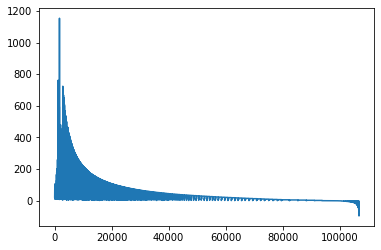

In [34]:
plt.plot([r[1][2] for r in tags_with_rating])

По данному графику также видна явная корелляция между рейтингом статей и популярностью тегов, которые в этой статье указаны. Это можно объяснить тем, что непопулярные статьи реже читают и меньшее количество пользователей оценивает их положительно (даже если процентное соотношение между пользователями, оценившими положительно и отрицательно будет в пользу статьи)

Проделаем то же самое для хабов

In [35]:
all_reader = reader.read(filename)

In [36]:
hubs_names = [t[0] for t in hubs]

In [37]:
hubs_with_rating = {}

for article in tqdm(all_reader):
  for hub in article['hubs']:
    hub = hub.lower()
    if hub in hubs_names:
      if hub not in hubs_with_rating.keys():
        hubs_with_rating[hub] = [article['rating'], 1]
      else:
        hubs_with_rating[hub][0] += article['rating']
        hubs_with_rating[hub][1] += 1

hubs_with_rating

0it [00:00, ?it/s]

{'*nix': [13944, 398],
 '.net': [32537, 1611],
 '1с': [280, 25],
 '1с-битрикс': [71, 39],
 '3d-принтеры': [4759, 139],
 'accessibility': [917, 35],
 'action script': [497, 25],
 'adobe flash': [5797, 220],
 'agile': [1805, 106],
 'ajax': [1827, 90],
 'amazon web services': [2276, 160],
 'angular': [2120, 106],
 'apache': [329, 33],
 'apache flex': [157, 14],
 'api': [3863, 195],
 'ar и vr': [4259, 137],
 'asp': [2723, 164],
 'assembler': [9647, 144],
 'asterisk': [1463, 120],
 'atlassian': [572, 20],
 'big data': [3898, 232],
 'brainfuck': [560, 20],
 'c': [7064, 161],
 'c#': [10465, 494],
 'c++': [29796, 834],
 'cad/cam': [900, 62],
 'cakephp': [119, 26],
 'canvas': [3785, 94],
 'cgi (графика)': [15, 4],
 'cisco': [3028, 183],
 'clojure': [530, 18],
 'cms': [3379, 339],
 'cobol': [73, 5],
 'cocoa': [111, 12],
 'codeigniter': [664, 57],
 'coffeescript': [504, 21],
 'creative commons': [2128, 68],
 'crm-системы': [223, 46],
 'css': [31560, 664],
 'ctf': [382, 23],
 'cubrid': [63, 4],
 '

In [38]:
for key, value in hubs_with_rating.items():
  hubs_with_rating[key].append(value[0] / value[1])

hubs_with_rating = sorted(hubs_with_rating.items(), key=lambda item:item[1], reverse=True)
hubs_with_rating

[('чулан', [208423, 29343, 7.1029887877858435]),
 ('разработка веб-сайтов', [183378, 5459, 33.59186664224217]),
 ('информационная безопасность', [176341, 4100, 43.01]),
 ('it-компании', [173804, 7010, 24.793723252496434]),
 ('я пиарюсь', [128377, 4950, 25.934747474747475]),
 ('программирование', [104350, 2977, 35.05206583809204]),
 ('diy или сделай сам', [98721, 1360, 72.5889705882353]),
 ('настройка linux', [84538, 2283, 37.029347349978096]),
 ('компьютерное железо', [73581, 2292, 32.103403141361255]),
 ('гаджеты', [63259, 2269, 27.879682679594534]),
 ('javascript', [62820, 1928, 32.58298755186722]),
 ('разработка игр', [59344, 1477, 40.17874069058903]),
 ('алгоритмы', [55952, 1147, 48.781168265039234]),
 ('социальные сети и сообщества', [51625, 1782, 28.970258136924805]),
 ('разработка под android', [51497, 1981, 25.99545683997981]),
 ('научно-популярное', [50147, 1176, 42.64200680272109]),
 ('habr', [48809, 1636, 29.834352078239608]),
 ('open source', [48257, 1333, 36.20180045011253

In [39]:
import numpy as np

x = np.arange(0, len(hubs_with_rating))
y = [r[1][2] for r in hubs_with_rating]

p = np.polyfit(x,y, 1)
ya = np.polyval(p, x)

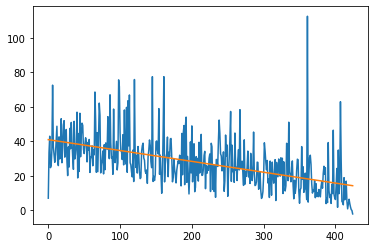

In [40]:
plt.plot(x, y)
plt.plot(x, ya)

Связь между популярностью хабов и рейтингом значительно менее явная. Однако линейная аппроксимация показывает, что она имеет место. Не такое значительное влияние можно попытаться объяснить тем, что так как тегов, гораздо большее количество, то и разность между самыми популярными и самыми непопулярными в рейтинге будет больше.

Попробуем доказать это предположение посчитав некоторые статистические храрктеристики.

In [59]:
hub_popularity = [a[1][1] for a in hubs_with_rating]
hubs_rating = [a[1][-1] for a in hubs_with_rating]
np.mean(hub_popularity), np.std(hub_popularity), np.max(hubs_rating) - np.min(hubs_rating)

(329.87529411764706, 1545.9169084973018, 114.5)

In [60]:
tag_popularity = [a[1][1] for a in tags_with_rating]
tags_rating = [a[1][-1] for a in tags_with_rating]
np.mean(tag_popularity), np.std(tag_popularity), np.max(tags_rating) - np.min(tags_rating)

(4.954375222365785, 38.43643915576713, 1250.0)

Предположение подтвердилось. Несмотря на значительно меньшее среднеквадратическое отклонение в популярности (что объясняется огромным количеством совершенно непопулярных тегов) размах в рейтингах для тегов примерно в 10 раз больше.

Напоследок, проверим зависимость между рейтингом статьи и количеством изображений в статье. Есть предположение, что более качественные статьи отличаются хорошим подбором иллюстраций. Давайте его проверим.

In [45]:
all_reader = reader.read(filename)

In [ ]:
figures = {}

for article in tqdm(all_reader):
  fig_count = len(article['figures'])
  rating = article['rating']
  if fig_count not in figures:
    figures[fig_count] = [rating, 1]
  else:
    figures[fig_count][0] += rating
    figures[fig_count][1] += 1

In [ ]:
for key, value in figures.items():
  figures[key].append(value[0] / value[1])

figures = sorted(figures.items(), key=lambda item: item[0], reverse=False)

In [48]:
figures = [f[1][-1] for f in figures]
figures

[26.616771874085533,
 8.40880195599022,
 11.313829787234043,
 9.921465968586388,
 13.364197530864198,
 12.413793103448276,
 18.032967032967033,
 13.017241379310345,
 15.63888888888889,
 21.05982905982906,
 15.16842105263158,
 18.98780487804878,
 14.147540983606557,
 21.476190476190474,
 17.692307692307693,
 16.925,
 14.485714285714286,
 18.0,
 17.73913043478261,
 13.736842105263158,
 12.533333333333333,
 16.7,
 32.578947368421055,
 17.357142857142858,
 18.083333333333332,
 31.166666666666668,
 15.9,
 29.0,
 9.545454545454545,
 27.666666666666668,
 10.25,
 32.0,
 11.333333333333334,
 24.75,
 15.0,
 13.833333333333334,
 9.6,
 20.0,
 9.666666666666666,
 3.0,
 22.25,
 23.0,
 42.333333333333336,
 0.0,
 5.0,
 24.666666666666668,
 4.0,
 0.0,
 71.0,
 28.0,
 47.0,
 80.0,
 6.0,
 67.0,
 17.0,
 0.5,
 12.0,
 10.5,
 23.0,
 19.0,
 4.0,
 9.0,
 5.0]

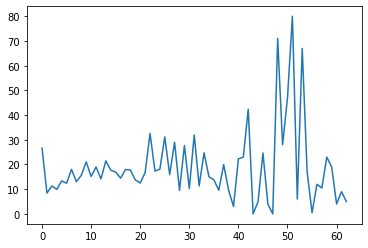

In [49]:
plt.plot(figures)

По графику видно, что зависимости между рейтингом и количеством картинок в статье в принципе нет.

Как бы то ни было, можем составить список признаков, которые предполагаются для дальнейшего использования.

- Название - можно использовать название в задачах классификации и кластеризации, используя n-граммы, word2vec и прочие модели.
- ~Длина названия~
- Длина текста статьи
- ~Текст статьи~ - это очень большое количество данных для обработки, в дальнейшем можно попытаться придумать, как разбивать эти данные и искать в них более важные составляющие, пока что откажемся от использования всего текста статьи
- ~Количество картинок в статье~
- Теги
- Хабы
- _Рейтинг - целевой показатель, используемый для предсказаний_

Используя данный список, составим датасет.

In [50]:
import pandas as pd

In [51]:
all_reader = reader.read(filename)

In [53]:
df = {
    'title': [],
    'body_length': [],
    'tags': [],
    'hubs': [],
    'rating': []
}

In [54]:
for article in tqdm(all_reader):
  df['title'].append(article['title'])
  df['body_length'].append(len(reader.clean(article['main_body']).split()))
  df['tags'].append(article['tags'])
  df['hubs'].append(article['hubs'])
  df['rating'].append(article['rating'])

0it [00:00, ?it/s]

In [55]:
df = pd.DataFrame.from_dict(df)
df

,title,body_length,tags,hubs,rating
0,Хранение кода в SCM,13707,"[git, git workflow, scm, devops, notops]","[DevOps, Git]",0
1,Почта для домена в Telegram,1760,"[open-source, email]","[Open source, PHP]",0
2,Понимание оценки BLEU в кастомизированном маши...,13034,"[google translate, машинный перевод, bleu, nlp...","[Машинное обучение, Natural Language Processing]",0
3,"Антисолнечная батарея. Солнечная панель, котор...",4099,"[солнечная энергетика, виэ, энергия, солнце, б...","[Блог компании Timeweb Cloud, Научно-популярно...",1
4,РКК «Энергия» получила патент на лунный экскав...,1203,"[ркк энергия, роскосмос, луна, луна-25, лунная...","[Патентование, Космонавтика]",3
...,...,...,...,...,...
124458,Введение в компоненты derby 0.6,13328,"[derbyjs, derby.js, реактивное программировани...","[Разработка веб-сайтов, JavaScript, Derby.js]",15
124459,Проблематика получения преимуществ с помощью б...,9013,[компьютерные игры],"[Спортивное программирование, Разработка игр]",-11
124460,Sol 613: сферическая интерактивная панорама Cu...,552,"[панорамы, марс, curiosity]","[Робототехника, Фототехника, Космонавтика]",37
124461,3 проекта недорогих мини-ПК с Indiegogo,2116,"[Indiegogo, краудфандинг, электроника, raspber...",[Разработка на Raspberry Pi],49


In [56]:
df.to_csv('habr.csv')